In [2]:
!pip install kneed

# Setup and Dependencies

In [3]:
# Import all required libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from kneed import KneeLocator
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set the aesthetics for plots

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Data Loading and Basic Information

In [6]:
# Load the dataset and display basic information about it
data = pd.read_csv('/content/ObesityDataSet_raw_and_data_sinthetic.csv')

# Display basic info about the dataset
print("Dataset Shape:", data.shape)
print("\nData Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())
print("\nFirst 5 rows:")
print(data.head())

Dataset Shape: (2111, 17)

Data Types:
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

Missing Values:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0


# 2. Data Preprocessing

In [7]:
# Prepare data for analysis by creating binary target and handling categorical features
# Create binary obesity target
def classify_binary_obesity(obesity_level):
    obese_categories = ['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
    return 'Obese' if obesity_level in obese_categories else 'Not_Obese'

data['BinaryObesity'] = data['NObeyesdad'].apply(classify_binary_obesity)

# Select features for analysis
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Handle categorical features
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
data_scaled = data_encoded.copy()
data_scaled[numeric_features] = scaler.fit_transform(data_scaled[numeric_features])

# Features for unsupervised learning (excluding target variables)
X = data_scaled.drop(['NObeyesdad', 'BinaryObesity'], axis=1)

print("\nFeatures for unsupervised learning:")
print(X.columns.tolist())


Features for unsupervised learning:
['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']


# 3. Exploratory Data Analysis - Distribution Visualizations

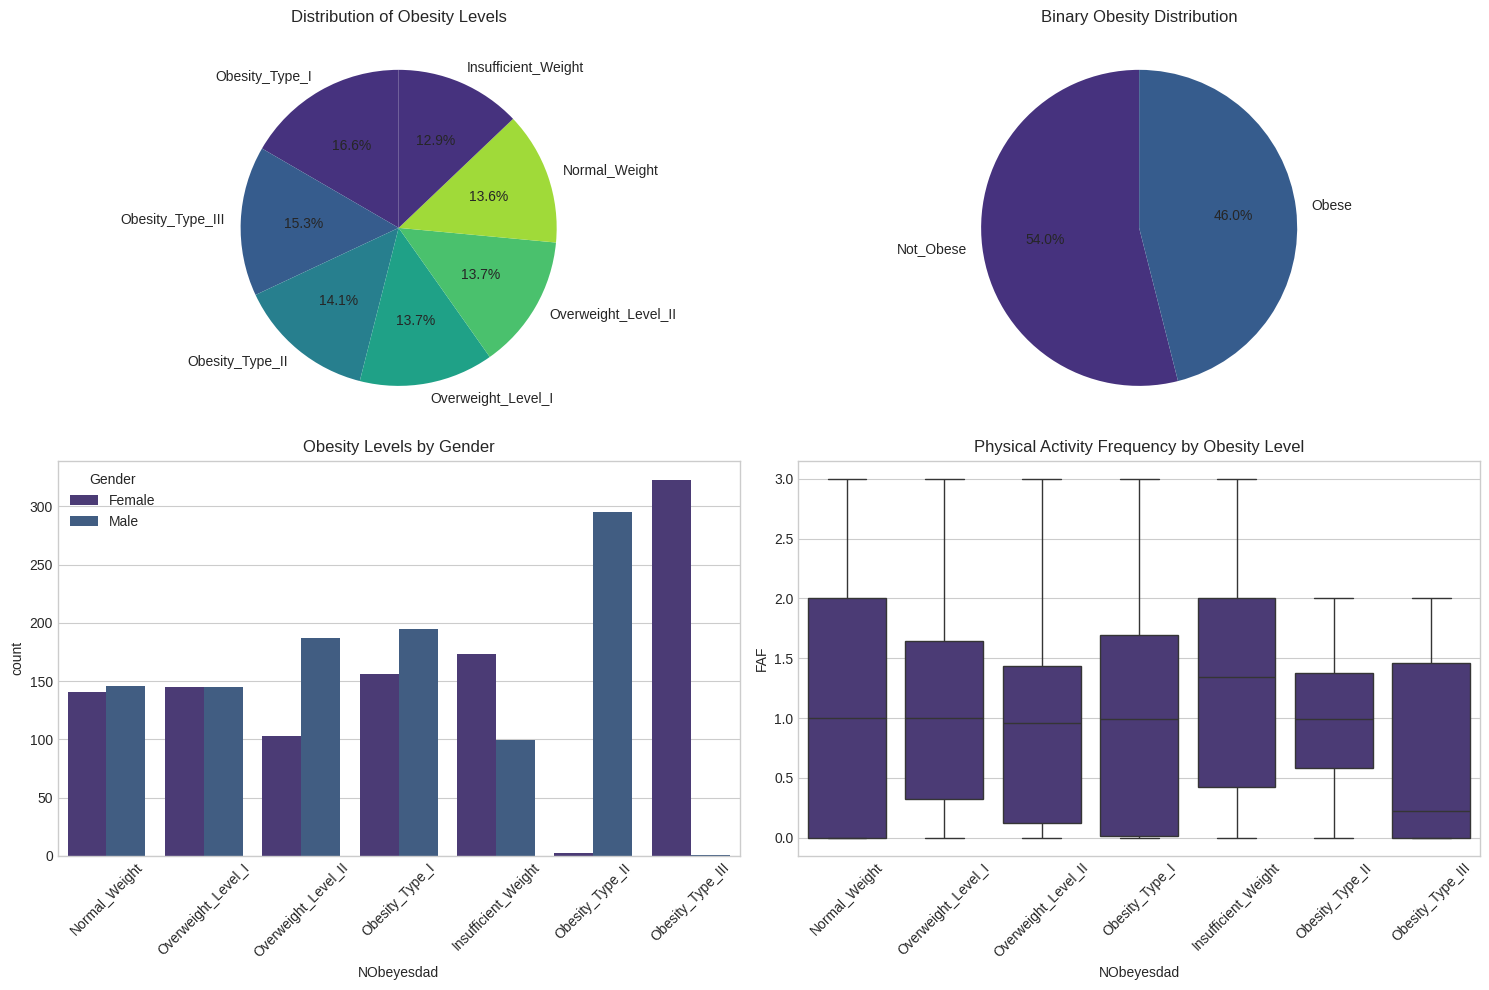

In [8]:
# Visualize the distribution of obesity levels and related variables
plt.figure(figsize=(15, 10))

# Overall obesity level distribution
plt.subplot(2, 2, 1)
obesity_counts = data['NObeyesdad'].value_counts()
plt.pie(obesity_counts, labels=obesity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Obesity Levels')

# Binary obesity distribution
plt.subplot(2, 2, 2)
binary_counts = data['BinaryObesity'].value_counts()
plt.pie(binary_counts, labels=binary_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Binary Obesity Distribution')

# Obesity levels by gender
plt.subplot(2, 2, 3)
sns.countplot(x='NObeyesdad', hue='Gender', data=data)
plt.title('Obesity Levels by Gender')
plt.xticks(rotation=45)
plt.tight_layout()

# Physical activity vs obesity levels
plt.subplot(2, 2, 4)
sns.boxplot(x='NObeyesdad', y='FAF', data=data)
plt.title('Physical Activity Frequency by Obesity Level')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('obesity_eda.png', bbox_inches='tight')
plt.show()

# 4. Exploratory Data Analysis - Correlation Analysis

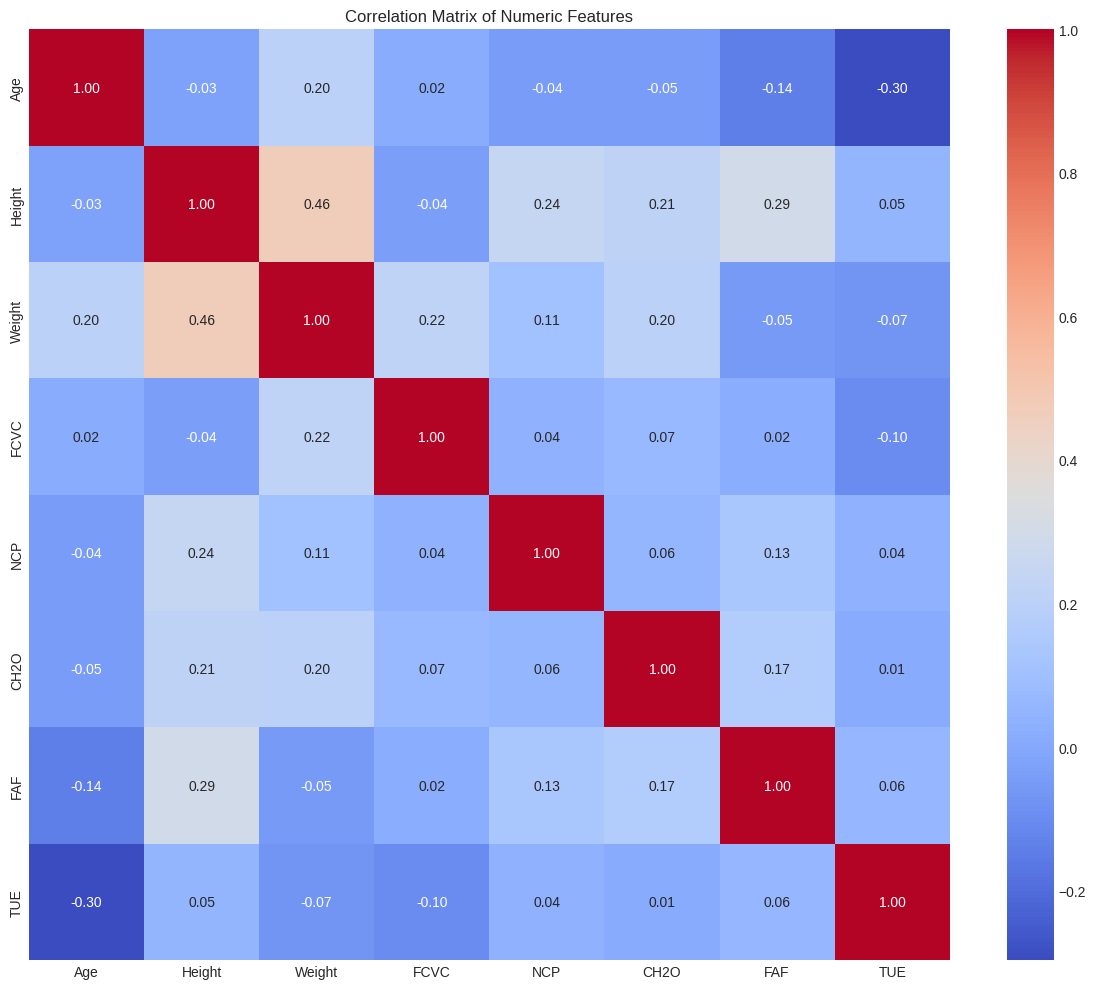

In [9]:
# Analyze correlations between numeric features
plt.figure(figsize=(12, 10))
corr_matrix = data[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()

# 5. Principal Component Analysis (PCA)

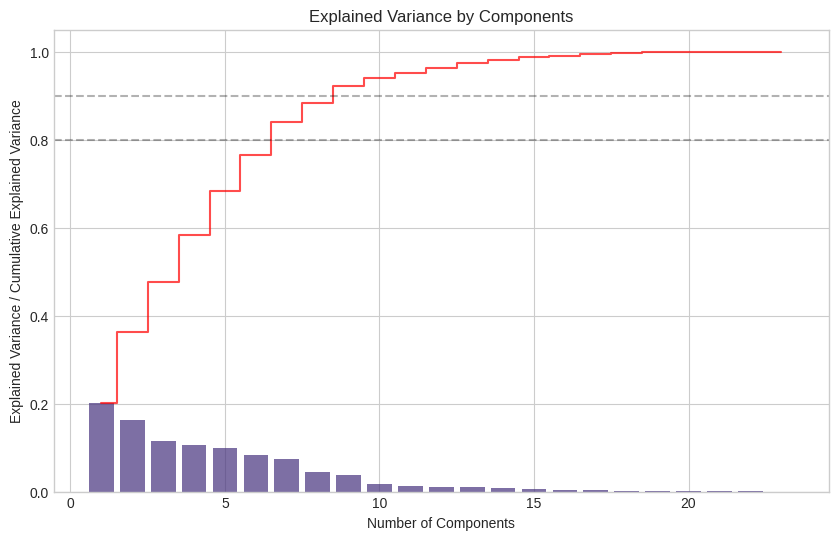

Number of components explaining 80% of variance: 7


In [10]:
# Reduce dimensionality and identify important components
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)



# Plot explained variance
plt.figure(figsize=(10, 6))
explained_variance = pca.explained_variance_ratio_
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', color='red', alpha=0.7)
plt.axhline(y=0.8, color='k', linestyle='--', alpha=0.3)
plt.axhline(y=0.9, color='k', linestyle='--', alpha=0.3)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance / Cumulative Explained Variance')
plt.grid(True)
plt.savefig('pca_variance.png', bbox_inches='tight')
plt.show()

# Determine the number of components that explain 80% of variance
n_components = np.argmax(np.cumsum(explained_variance) >= 0.8) + 1
print(f"Number of components explaining 80% of variance: {n_components}")

# 6. PCA - Dimensionality Reduction and Feature Importance

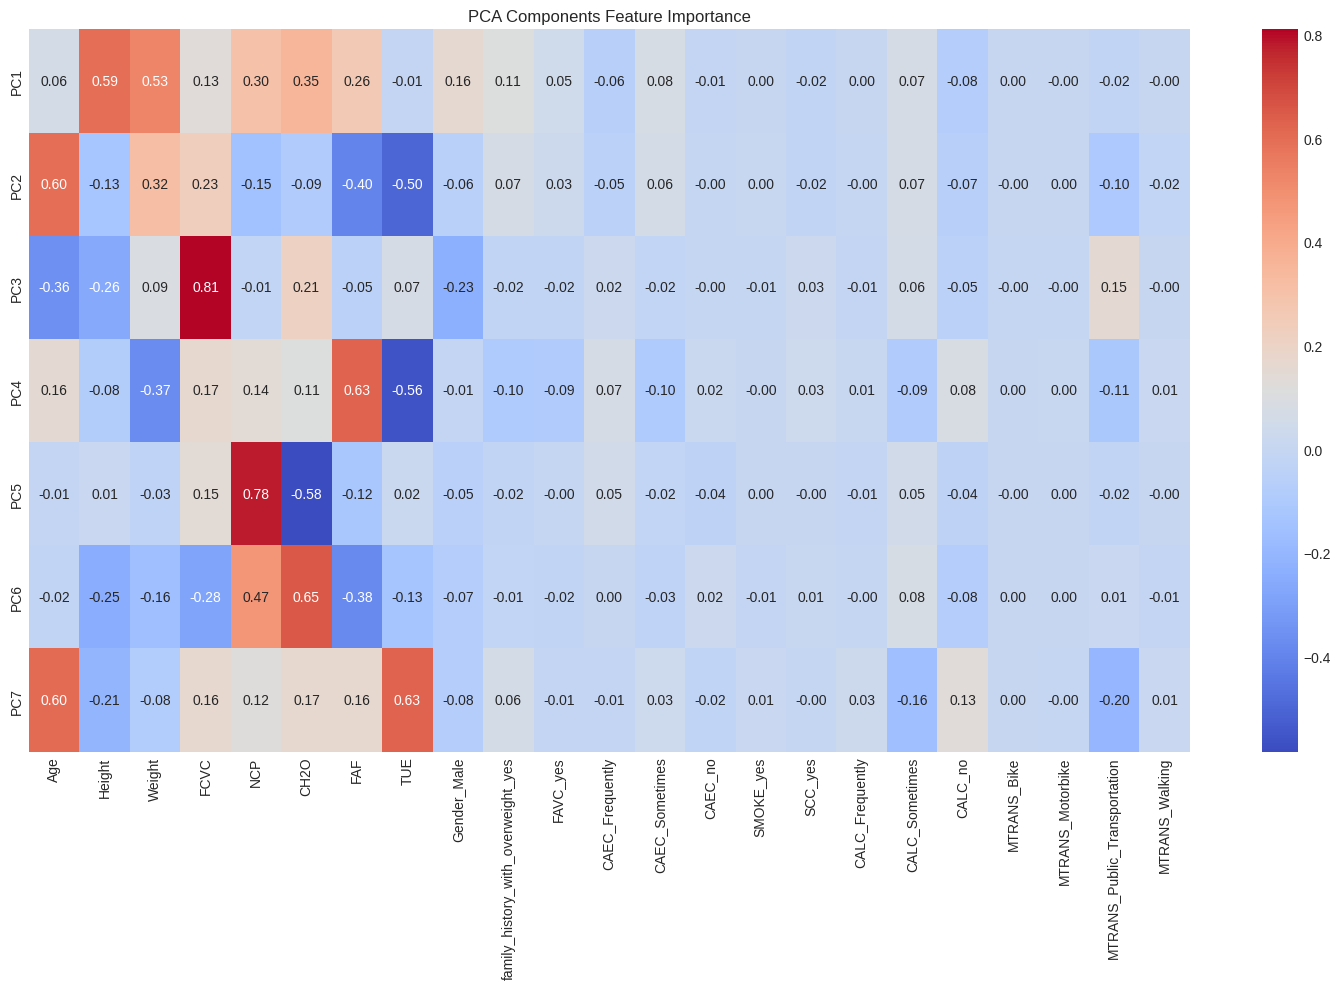

In [11]:
# Reduce to selected number of components and analyze their composition
# Reduce to the selected number of components
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X)

# Feature importance in PCA
pca_components = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f'PC{i+1}' for i in range(n_components)]
)

plt.figure(figsize=(15, 10))
sns.heatmap(pca_components, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('PCA Components Feature Importance')
plt.tight_layout()
plt.savefig('pca_components.png', bbox_inches='tight')
plt.show()

# 7. PCA Visualization - 3D Scatter Plot

In [12]:
# Visualize PCA components in 3D space colored by obesity levels
if len(X_pca_reduced[0]) >= 3:
    fig = px.scatter_3d(
        x=X_pca_reduced[:, 0],
        y=X_pca_reduced[:, 1],
        z=X_pca_reduced[:, 2],
        color=data['NObeyesdad'],
        title='PCA - First Three Components',
        labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'}
    )
    fig.update_layout(legend_title_text='Obesity Level')
    fig.write_html('pca_3d.html')
    fig.show()

# 8. K-means Clustering - Finding Optimal K

In [13]:
# Use Elbow Method and Silhouette Score to determine optimal number of clusters
inertia = []
silhouette_scores = []
range_of_k = range(2, 11)

for k in range_of_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_reduced)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_pca_reduced, labels)
    silhouette_scores.append(silhouette_avg)

    print(f"K={k}, Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.4f}")

K=2, Inertia=14177.86, Silhouette Score=0.1559
K=3, Inertia=12497.49, Silhouette Score=0.1601
K=4, Inertia=11128.45, Silhouette Score=0.1874
K=5, Inertia=10187.33, Silhouette Score=0.1767
K=6, Inertia=9315.01, Silhouette Score=0.1835
K=7, Inertia=8736.57, Silhouette Score=0.1809
K=8, Inertia=8220.29, Silhouette Score=0.1859
K=9, Inertia=7866.23, Silhouette Score=0.1943
K=10, Inertia=7512.58, Silhouette Score=0.1965


# 9. K-means Clustering - Visualization of Optimal K

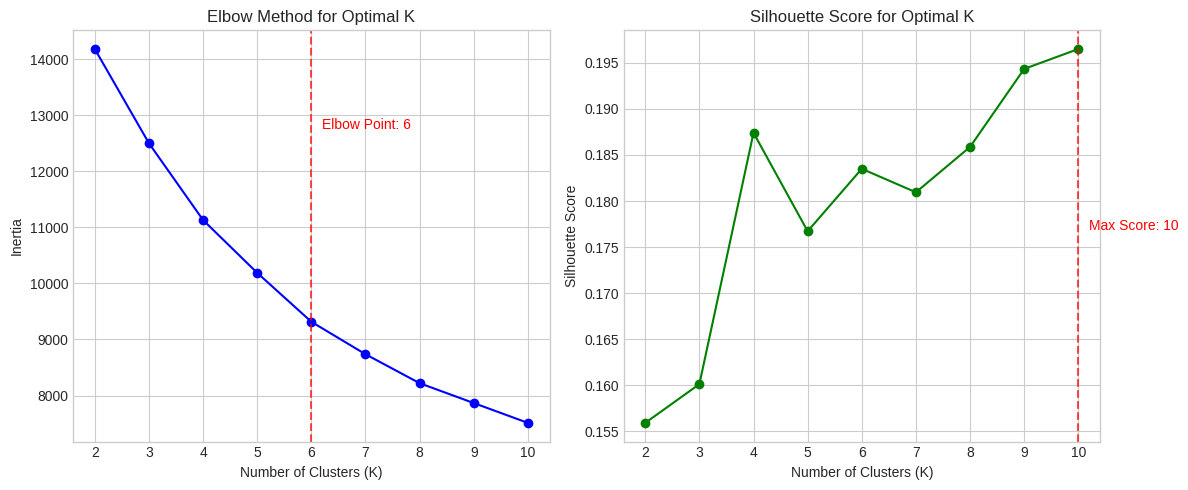


Optimal K based on Elbow Method: 6
Optimal K based on Silhouette Score: 10


In [14]:
# Visualize Elbow Method and Silhouette Score for optimal cluster selection
plt.figure(figsize=(12, 5))

# Inertia (Elbow Method)
plt.subplot(1, 2, 1)
plt.plot(range_of_k, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)

# Use knee locator to find the elbow point
kl = KneeLocator(range_of_k, inertia, curve='convex', direction='decreasing')
if kl.elbow:
    plt.axvline(x=kl.elbow, color='r', linestyle='--', alpha=0.7)
    plt.text(kl.elbow+0.2, max(inertia)*0.9, f'Elbow Point: {kl.elbow}', color='r')
    optimal_k_elbow = kl.elbow
else:
    optimal_k_elbow = 4  # default if knee not found

# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range_of_k, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.grid(True)

# Find k with maximum silhouette score
optimal_k_silhouette = range_of_k[np.argmax(silhouette_scores)]
plt.axvline(x=optimal_k_silhouette, color='r', linestyle='--', alpha=0.7)
plt.text(optimal_k_silhouette+0.2, max(silhouette_scores)*0.9, f'Max Score: {optimal_k_silhouette}', color='r')

plt.tight_layout()
plt.savefig('kmeans_optimization.png', bbox_inches='tight')
plt.show()

print(f"\nOptimal K based on Elbow Method: {optimal_k_elbow}")
print(f"Optimal K based on Silhouette Score: {optimal_k_silhouette}")

# 10. K-means Clustering Implementation

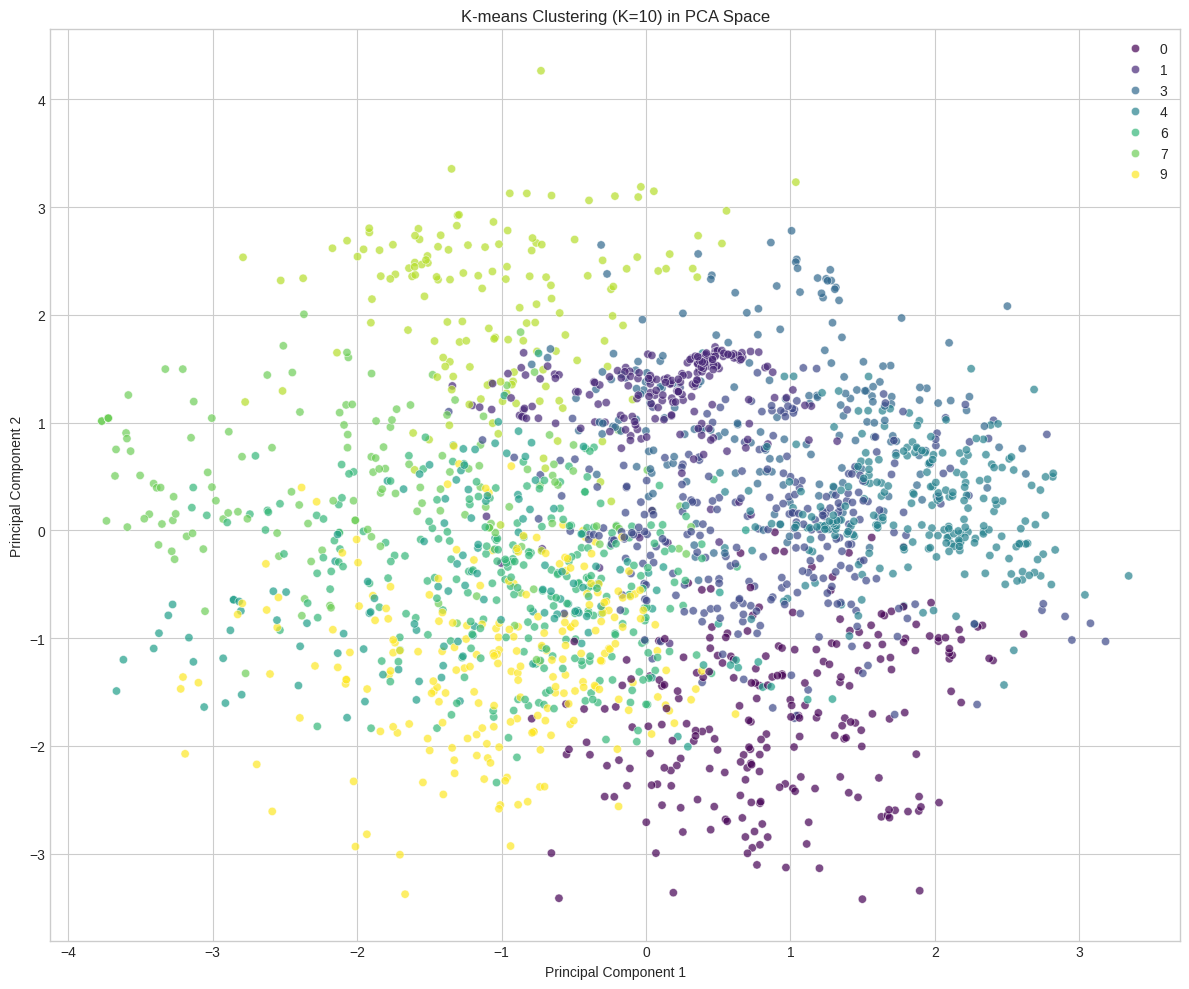

In [15]:
# Apply K-means with optimal K value and visualize clusters
# Use the optimal k value (prioritize silhouette score if they differ)
optimal_k = optimal_k_silhouette

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca_reduced)

# Add cluster labels to original data
data['Cluster'] = cluster_labels

# Visualize the clusters in PCA space (first 2 components)
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca_reduced[:, 0], y=X_pca_reduced[:, 1], hue=cluster_labels, palette='viridis', alpha=0.7)
plt.title(f'K-means Clustering (K={optimal_k}) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.savefig('kmeans_clusters_pca.png', bbox_inches='tight')
plt.show()

# 11. Hierarchical Clustering - Dendrogram

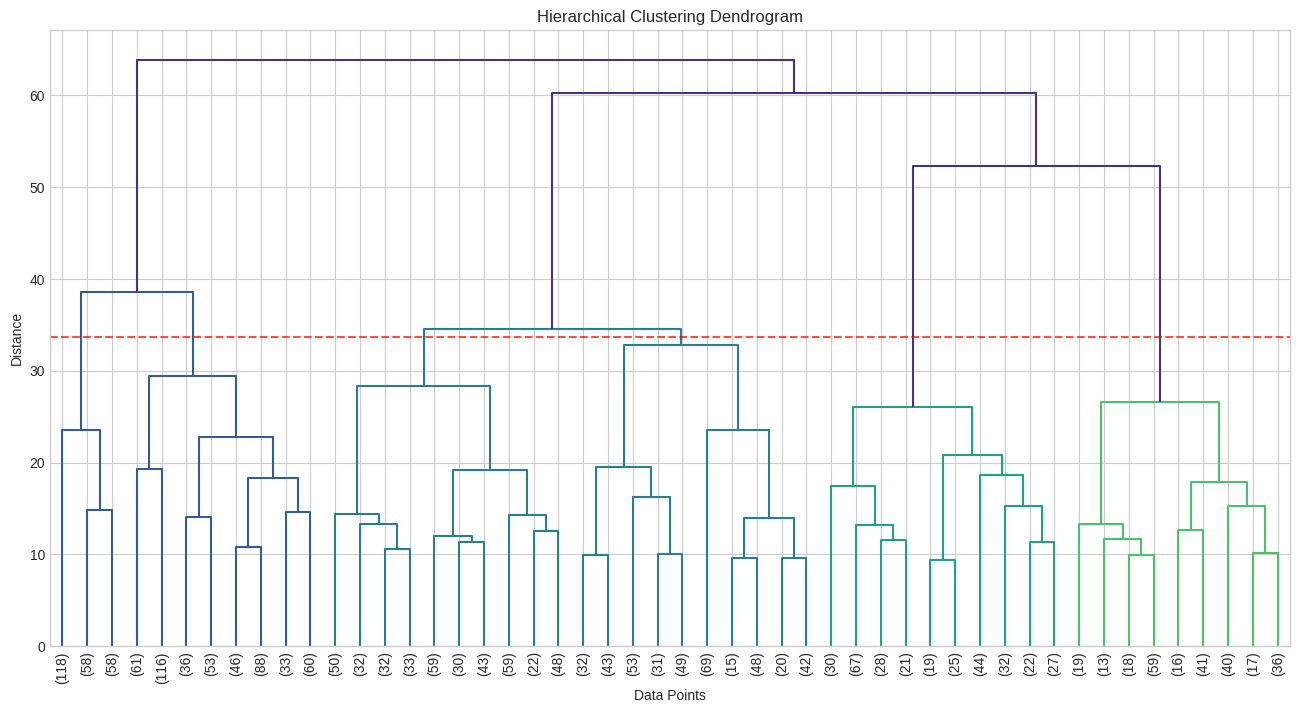

In [16]:
# Perform hierarchical clustering and visualize dendrogram
# Calculate linkage matrix
Z = shc.linkage(X_pca_reduced, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
shc.dendrogram(Z, truncate_mode='lastp', p=50, leaf_font_size=10)
plt.axhline(y=np.median(Z[-optimal_k:, 2]), color='r', linestyle='--', alpha=0.7)
plt.savefig('hierarchical_dendrogram.png', bbox_inches='tight')
plt.show()

# 12. Hierarchical Clustering Implementation

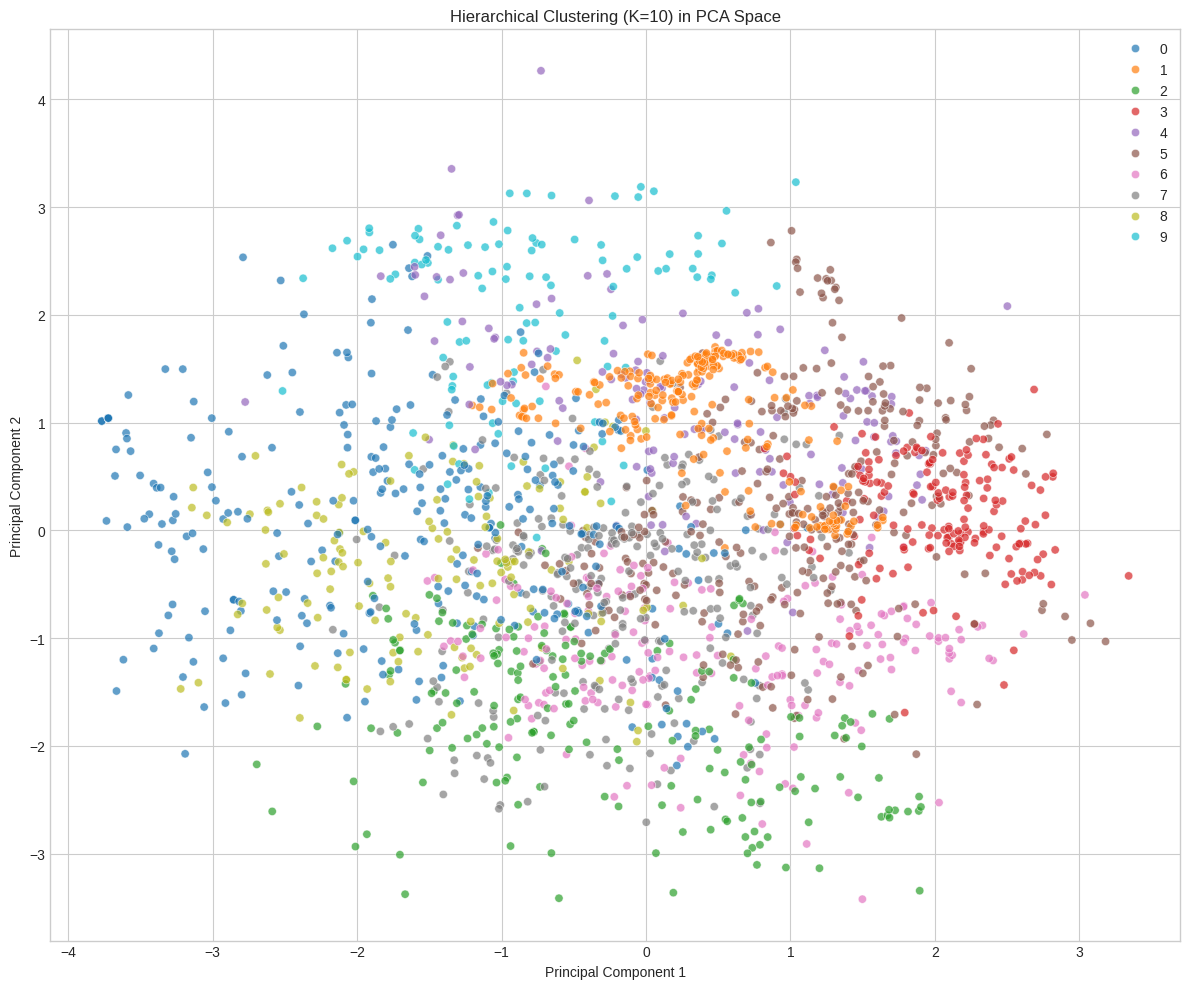

In [17]:
# Apply hierarchical clustering with optimal K and visualize results
# Apply hierarchical clustering with optimal k from K-means
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarch_labels = hierarchical.fit_predict(X_pca_reduced)

# Add hierarchical labels to original data
data['HierarchicalCluster'] = hierarch_labels

# Visualize the hierarchical clusters in PCA space
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca_reduced[:, 0], y=X_pca_reduced[:, 1], hue=hierarch_labels, palette='tab10', alpha=0.7)
plt.title(f'Hierarchical Clustering (K={optimal_k}) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.savefig('hierarchical_clusters_pca.png', bbox_inches='tight')
plt.show()

# 13. Cluster Analysis - Comparing with Obesity Classifications

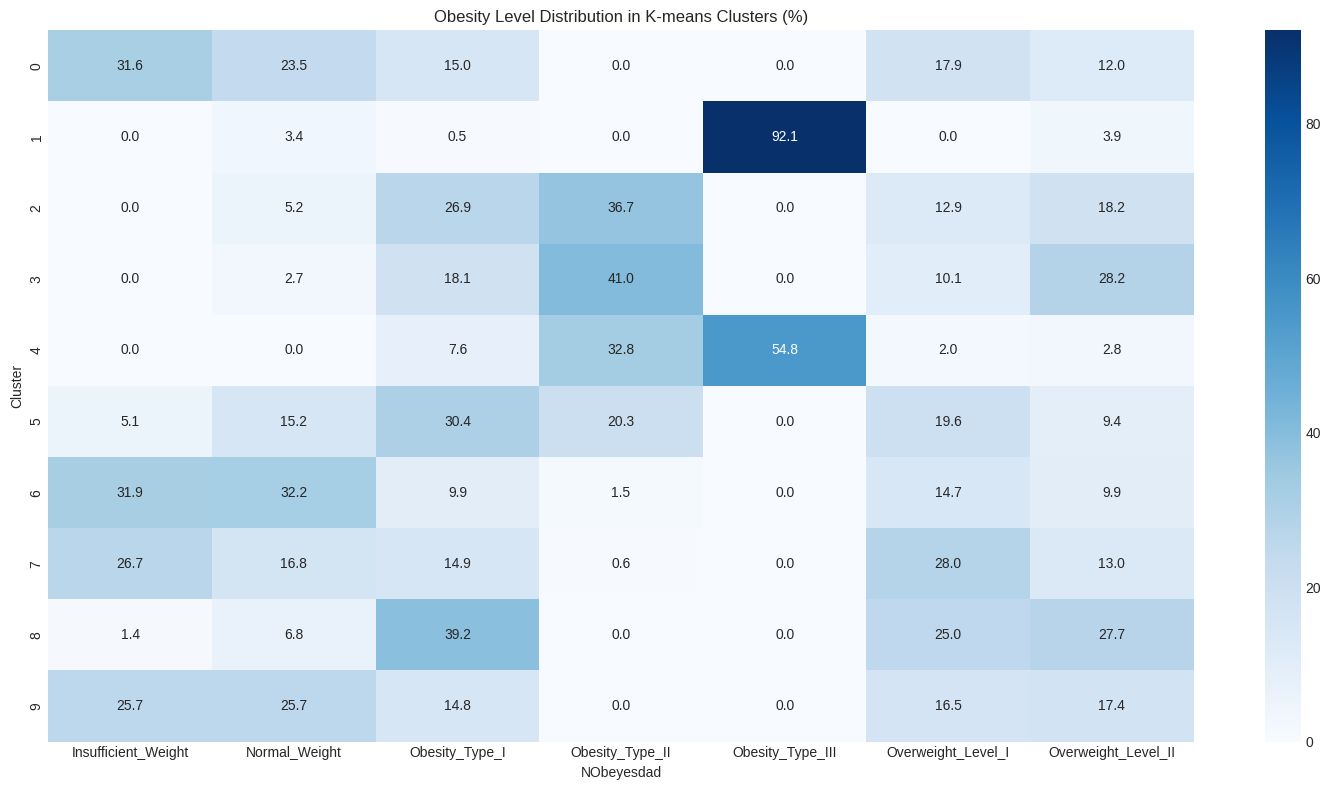

In [18]:
# Compare K-means clusters with actual obesity levels
# For K-means clusters
kmeans_comparison = pd.crosstab(
    data['Cluster'],
    data['NObeyesdad'],
    normalize='index'
) * 100  # Convert to percentages

plt.figure(figsize=(15, 8))
sns.heatmap(kmeans_comparison, annot=True, cmap='Blues', fmt='.1f')
plt.title('Obesity Level Distribution in K-means Clusters (%)')
plt.tight_layout()
plt.savefig('kmeans_vs_obesity.png', bbox_inches='tight')
plt.show()

# 14. Cluster Analysis - Binary Obesity Comparison

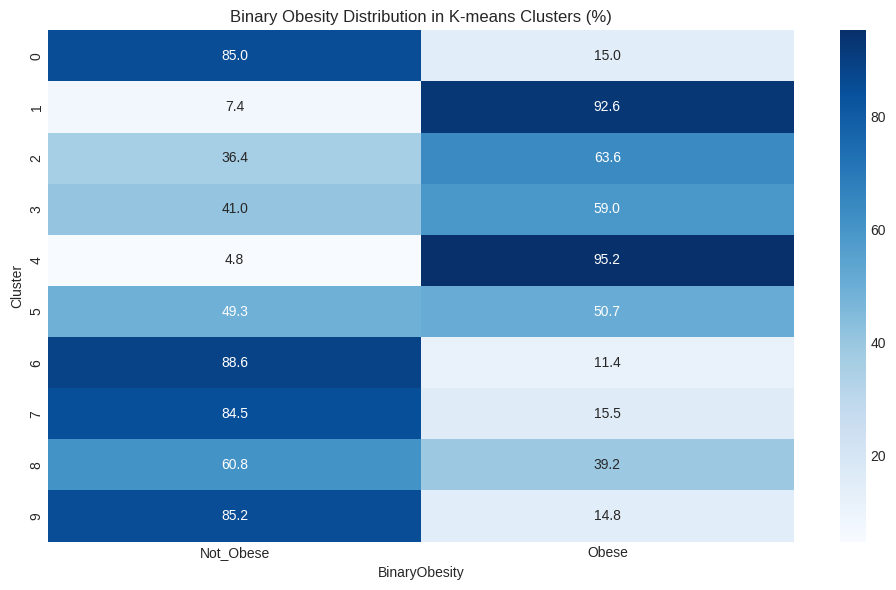

In [19]:
# Compare clusters with binary obesity classification
# For binary obesity
binary_comparison = pd.crosstab(
    data['Cluster'],
    data['BinaryObesity'],
    normalize='index'
) * 100  # Convert to percentages

plt.figure(figsize=(10, 6))
sns.heatmap(binary_comparison, annot=True, cmap='Blues', fmt='.1f')
plt.title('Binary Obesity Distribution in K-means Clusters (%)')
plt.tight_layout()
plt.savefig('kmeans_vs_binary_obesity.png', bbox_inches='tight')
plt.show()

# 15. Hierarchical Clustering - Obesity Comparison

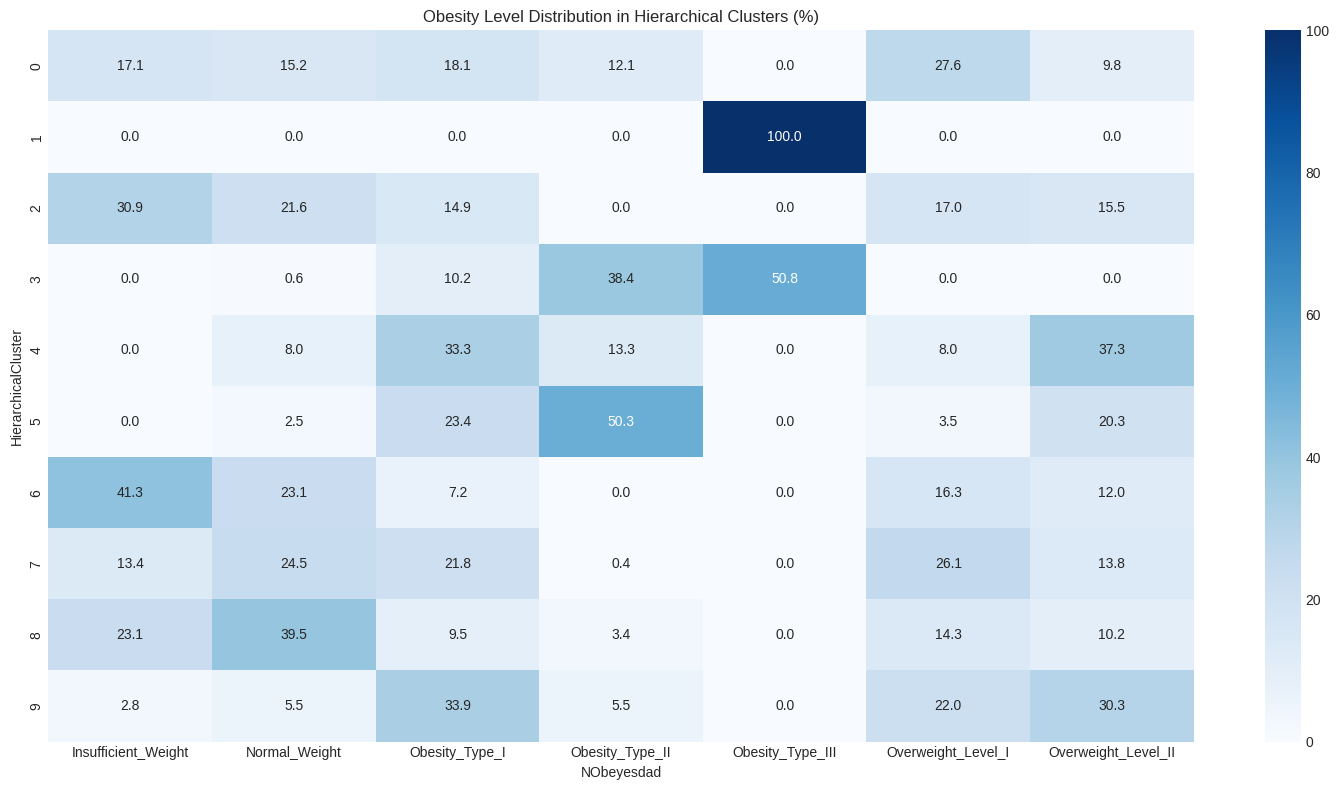

In [20]:
# Compare hierarchical clusters with obesity classifications
# Create comparison for hierarchical clustering
hierarch_comparison = pd.crosstab(
    data['HierarchicalCluster'],
    data['NObeyesdad'],
    normalize='index'
) * 100  # Convert to percentages

plt.figure(figsize=(15, 8))
sns.heatmap(hierarch_comparison, annot=True, cmap='Blues', fmt='.1f')
plt.title('Obesity Level Distribution in Hierarchical Clusters (%)')
plt.tight_layout()
plt.savefig('hierarchical_vs_obesity.png', bbox_inches='tight')
plt.show()

# 16. Cluster Profiling - Numeric Features

In [21]:
# Create profiles of clusters using numeric features
# K-means cluster profiles
kmeans_profiles = data.groupby('Cluster').agg({
    'Age': 'mean',
    'Height': 'mean',
    'Weight': 'mean',
    'FCVC': 'mean',
    'NCP': 'mean',
    'CH2O': 'mean',
    'FAF': 'mean',
    'TUE': 'mean'
}).round(2)

print("K-means Cluster Profiles (Numeric Features):")
print(kmeans_profiles)

K-means Cluster Profiles (Numeric Features):
           Age  Height  Weight  FCVC   NCP  CH2O   FAF   TUE
Cluster                                                     
0        20.27    1.77   72.87  2.37  3.17  2.41  2.25  0.98
1        25.44    1.64  106.33  2.99  3.00  2.19  0.10  0.48
2        23.94    1.77  100.79  1.93  2.92  2.17  0.73  0.52
3        33.54    1.77  100.25  2.42  2.47  1.87  1.46  0.26
4        22.84    1.78  127.11  2.91  2.94  2.26  1.30  0.77
5        21.09    1.66   81.67  2.35  1.24  1.86  0.67  1.42
6        20.69    1.64   61.27  2.64  3.13  1.81  1.26  0.42
7        21.83    1.61   63.29  2.38  1.14  1.96  0.69  0.16
8        38.58    1.62   75.09  2.38  2.56  1.75  0.53  0.20
9        20.75    1.67   66.92  1.87  3.04  1.60  0.66  1.33


# 17. Cluster Profiling - Radar Chart

In [22]:
# 17. Cluster Profiling - Radar Chart
# Visualize cluster profiles using radar charts
# Create a radar chart for cluster profiles
categories = numeric_features
fig = make_subplots(rows=1, cols=1)

# Scale the profiles for the radar chart
scaled_profiles = kmeans_profiles.copy()
for feature in numeric_features:
    min_val = data[feature].min()
    max_val = data[feature].max()
    scaled_profiles[feature] = (scaled_profiles[feature] - min_val) / (max_val - min_val)

for i in range(optimal_k):
    values = scaled_profiles.iloc[i].values.tolist()
    values.append(values[0])  # Close the loop
    cats = categories + [categories[0]]  # Close the loop

    fig.add_trace(
        go.Scatterpolar(
            r=values,
            theta=cats,
            fill='toself',
            name=f'Cluster {i}'
        )
    )

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    title="K-means Cluster Profiles (Normalized)",
    showlegend=True
)
fig.write_html('cluster_profiles_radar.html')
fig.show()

# 18. Cluster Profiling - Categorical Features

In [ ]:
# Analyze distribution of categorical features across clusters
# Categorical feature distribution in clusters
cat_distributions = {}
for feature in categorical_features:
    cat_distributions[feature] = pd.crosstab(
        data['Cluster'],
        data[feature],
        normalize='index'
    ) * 100  # Convert to percentages

# Visualize a few key categorical distributions
key_categoricals = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC']
plt.figure(figsize=(16, 12))

for i, feature in enumerate(key_categoricals):
    plt.subplot(2, 2, i+1)
    sns.heatmap(cat_distributions[feature], annot=True, cmap='Blues', fmt='.1f')
    plt.title(f'{feature} Distribution in K-means Clusters (%)')

plt.tight_layout()
plt.savefig('categorical_distributions.png', bbox_inches='tight')
plt.show()

# 19. Final Analysis - Cluster Summary

In [23]:
# Create detailed summary of each cluster with key characteristics
# Create a summary of key characteristics for each cluster
cluster_summary = {}

for cluster in range(optimal_k):
    # Get the rows for this cluster
    cluster_data = data[data['Cluster'] == cluster]

    # Most common obesity level in this cluster
    top_obesity = cluster_data['NObeyesdad'].value_counts().index[0]
    obesity_percent = cluster_data['NObeyesdad'].value_counts(normalize=True)[0] * 100

    # Binary obesity percentage
    obese_percent = (cluster_data['BinaryObesity'] == 'Obese').mean() * 100

    # Key feature statistics
    avg_weight = cluster_data['Weight'].mean()
    avg_faf = cluster_data['FAF'].mean()  # Physical activity frequency

    cluster_summary[cluster] = {
        'Size': len(cluster_data),
        'Top_Obesity_Level': top_obesity,
        'Top_Obesity_Percentage': obesity_percent,
        'Obese_Percentage': obese_percent,
        'Avg_Weight': avg_weight,
        'Avg_Physical_Activity': avg_faf
    }

# Print summary
print("\nCluster Summary:")
for cluster, summary in cluster_summary.items():
    print(f"\nCluster {cluster}:")
    print(f"  Size: {summary['Size']} individuals ({summary['Size']/len(data)*100:.1f}% of data)")
    print(f"  Dominant Obesity Level: {summary['Top_Obesity_Level']} ({summary['Top_Obesity_Percentage']:.1f}%)")
    print(f"  Obese Individuals: {summary['Obese_Percentage']:.1f}%")
    print(f"  Average Weight: {summary['Avg_Weight']:.2f} kg")
    print(f"  Average Physical Activity: {summary['Avg_Physical_Activity']:.2f}")


Cluster Summary:

Cluster 0:
  Size: 234 individuals (11.1% of data)
  Dominant Obesity Level: Insufficient_Weight (31.6%)
  Obese Individuals: 15.0%
  Average Weight: 72.87 kg
  Average Physical Activity: 2.25

Cluster 1:
  Size: 203 individuals (9.6% of data)
  Dominant Obesity Level: Obesity_Type_III (92.1%)
  Obese Individuals: 92.6%
  Average Weight: 106.33 kg
  Average Physical Activity: 0.10

Cluster 2:
  Size: 286 individuals (13.5% of data)
  Dominant Obesity Level: Obesity_Type_II (36.7%)
  Obese Individuals: 63.6%
  Average Weight: 100.79 kg
  Average Physical Activity: 0.73

Cluster 3:
  Size: 188 individuals (8.9% of data)
  Dominant Obesity Level: Obesity_Type_II (41.0%)
  Obese Individuals: 59.0%
  Average Weight: 100.25 kg
  Average Physical Activity: 1.46

Cluster 4:
  Size: 250 individuals (11.8% of data)
  Dominant Obesity Level: Obesity_Type_III (54.8%)
  Obese Individuals: 95.2%
  Average Weight: 127.11 kg
  Average Physical Activity: 1.30

Cluster 5:
  Size: 138 

<ipython-input-23-6a09c8692692>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-23-6a09c8692692>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-23-6a09c8692692>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-23-6a09c8692692>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

# 20. Feature Importance Analysis

In [24]:
# Determine which features were most important in forming the clusters
# Feature importance in cluster formation
cluster_centers = kmeans.cluster_centers_
pca_components_df = pd.DataFrame(pca.components_, columns=X.columns)
transformed_centers = np.dot(cluster_centers, pca.components_)

# Calculate feature importance based on variance across cluster centers
feature_importance = {}
for i, feature in enumerate(X.columns):
    values = transformed_centers[:, i]
    feature_importance[feature] = np.var(values)

# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
top_features = sorted_features[:10]  # Top 10 features

print("\nTop 10 Important Features for Cluster Formation:")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")


Top 10 Important Features for Cluster Formation:
Age: 0.8512
NCP: 0.8425
Height: 0.5682
Weight: 0.5461
TUE: 0.5130
FAF: 0.5033
FCVC: 0.4522
CH2O: 0.1615
MTRANS_Public_Transportation: 0.0721
Gender_Male: 0.0689


# 21. Feature Importance Visualization

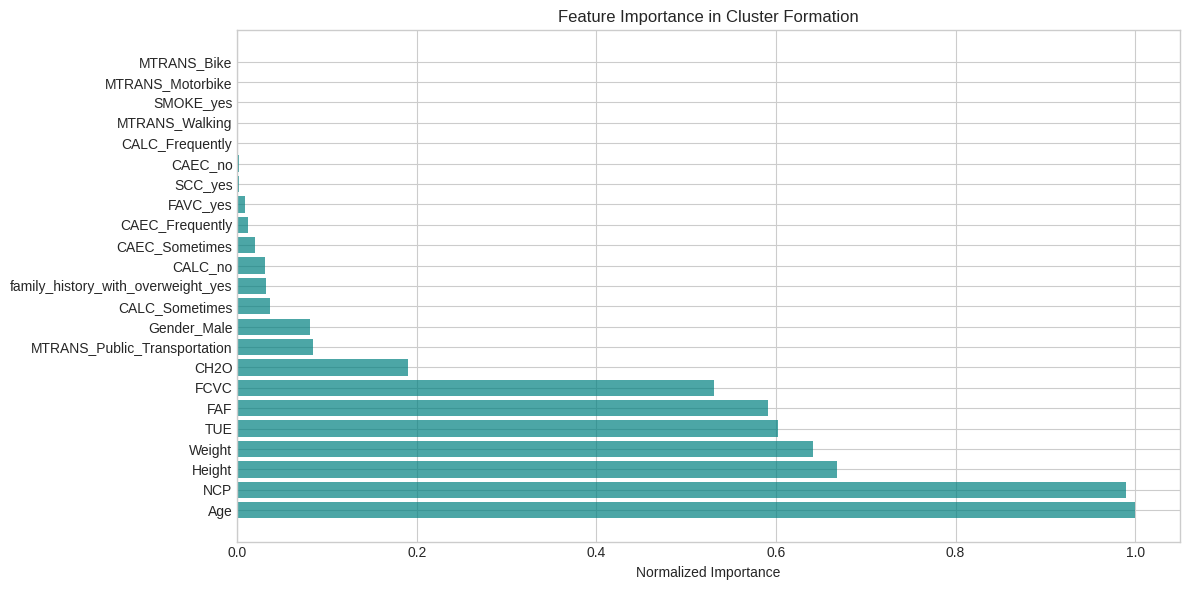

In [25]:
# Visualize feature importance with a horizontal bar chart
# Plot feature importance
plt.figure(figsize=(12, 6))
feature_names = [f[0] for f in sorted_features]
importance_values = [f[1] for f in sorted_features]

# Normalize importance for better visualization
norm_importance = np.array(importance_values) / max(importance_values)

plt.barh(feature_names, norm_importance, color='teal', alpha=0.7)
plt.xlabel('Normalized Importance')
plt.title('Feature Importance in Cluster Formation')
plt.tight_layout()
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

# 22. Save Results

In [27]:
# Save final dataset with cluster assignments for future use
# Save results for further analysis
data.to_csv('obesity_with_clusters.csv', index=False)
print("\nAnalysis complete. Results saved to CSV and image files.")


Analysis complete. Results saved to CSV and image files.
